# Run GalaxyGenius for Eagle Simulation

Although that GalaxyGenius is primarily designed for IllustrisTNG simulations, it can also perform galaxy generation for other simulations, with neccessary information retrieved from simulation and input to GalaxyGenius. 

Here we use [Eagle](https://icc.dur.ac.uk/Eagle/) simulation as an example.

## 1. Imports

In [1]:
import sys
sys.path.append('..')

from galaxyGenius.config import Configuration
from galaxyGenius.preprocess import PreProcess
from galaxyGenius.generation import DataGeneration
from galaxyGenius.postprocess import PostProcess

from typing import Union
from types import NoneType
import numpy as np
import pandas as pd
from astropy.cosmology import Cosmology, Planck13 # eagle simulation takes Planck13
import astropy.units as u
from astropy import constants as const
from scipy.interpolate import interp1d
import os
import h5py

## 2. Create configurations

The configuration files are created similarly demonstrated in tutorial.

In [2]:
from pathlib import Path
config_files = Path('.').glob('config*.toml')
for file in config_files:
    os.remove(file)


In [3]:
# Initialize configuration
config = Configuration()
conf = config.get_config()

GALAXYGENIUS_DATA_DIR not set. Data directory falling to default path: ../Data
No conflicts in config. 👍


In [4]:
config.add_survey('CSST, HSC')
conf = config.get_config()

CSST added.
HSC added.
No conflicts in config. 👍


In [5]:
# modify configs
conf['simulation'] = 'EAGLE'
conf['snapNum'] = 27
conf['numThreads'] = 24
conf['snapRedshift'] = 0.101

In [6]:
# manually save config
config.save_config(conf)

In [7]:
# reload config 
# Call this when config is further modified directly by file
conf = config.get_config()

No conflicts in config. 👍


## 3. Retrieve subhalo information from eagle

Subhalos can be retrieved using [eagleSqlTools](https://github.com/kyleaoman/eagleSqlTools).  Please refer to the Github for installation.

eagleSqlTools needs username and password, and can be registered [here](https://virgodb.dur.ac.uk/). 

In [8]:
import eagleSqlTools as sql

In [9]:
def build_query(keys: list, table_name: str, conditions: Union[list, NoneType] = None, order_by: Union[str, NoneType] = None):
    # Construct the SELECT clause with table alias
    alias = 'PROG'
    
    select_clause = ",\n    ".join([f"{alias}.{key}" for key in keys])
    query = f"SELECT\n    {select_clause}\nFROM\n    {table_name} AS {alias}"
    
    # Add WHERE conditions if provided
    if conditions:
        where_clause = " AND\n    ".join([f"{alias}.{key}" for key in conditions])
        query += f"\nWHERE\n    {where_clause}"
    
    # Add ORDER BY clause if provided
    if order_by:
        query += f"\nORDER BY\n    {alias}.{order_by}"
    
    return query

In [10]:
keys = [
    'GalaxyID', 'Redshift', 'MassType_Star',
    'CentreOfPotential_x', 'CentreOfPotential_y', 'CentreOfPotential_z',
    'HalfMassRad_Star', 'StarFormationRate'
]

# Image_face and Image_edge are urls of galaxy images at face-on and edge-on views of EAGLE simulation.
# keys_imgs = ['Image_face', 'Image_edge']
# keys = keys + keys_imgs

table_name = "RefL0100N1504_Subhalo"
alias = "PROG"
conditions = ["Snapnum = 27", "MassType_Star > 1.0e10"]
order_by = "MassType_Star DESC"

# Generate the query
query = build_query(keys, table_name, conditions, order_by)
print(query)

SELECT
    PROG.GalaxyID,
    PROG.Redshift,
    PROG.MassType_Star,
    PROG.CentreOfPotential_x,
    PROG.CentreOfPotential_y,
    PROG.CentreOfPotential_z,
    PROG.HalfMassRad_Star,
    PROG.StarFormationRate
FROM
    RefL0100N1504_Subhalo AS PROG
WHERE
    PROG.Snapnum = 27 AND
    PROG.MassType_Star > 1.0e10
ORDER BY
    PROG.MassType_Star DESC


In [11]:
# specify your username and password

username = 'username'
password = 'password'

In [12]:
# query subhalo data
con = sql.connect(user=username, password=password)
data = sql.execute_query(con, query)

if os.path.exists('sql_cookies.txt'):
    os.remove('sql_cookies.txt')

In [13]:
# save to h5 file
units = ['1', '1', 'Msun', 
         'cMpc', 'cMpc', 'cMpc',
         'pkpc', 'Msun/yr']

df = pd.DataFrame(data, columns=keys)
df.attrs['units'] = units

df.to_hdf('EAGLE_subhalos.h5', key='data', mode='w')

In [14]:
df = pd.read_hdf('EAGLE_subhalos.h5', key='data')

In [15]:
df

,GalaxyID,Redshift,MassType_Star,CentreOfPotential_x,CentreOfPotential_y,CentreOfPotential_z,HalfMassRad_Star,StarFormationRate
0,21379522,0.100639,1.696923e+12,5.717667,75.610413,47.477654,189.744186,25.717649
1,21730536,0.100639,1.693157e+12,52.425648,4.996927,20.125082,120.196869,36.118923
2,21573587,0.100639,1.465913e+12,9.122603,35.035015,54.523602,131.478226,34.501350
3,21242351,0.100639,1.275125e+12,10.956322,81.293434,54.890770,72.678612,17.381081
4,21109761,0.100639,1.116979e+12,18.116920,79.885033,53.512390,60.974213,9.897696
...,...,...,...,...,...,...,...,...
3682,12133568,0.100639,1.001692e+10,73.024933,27.232883,62.192871,4.242476,0.798123
3683,11625097,0.100639,1.001292e+10,66.970421,48.385468,94.945625,3.916933,0.463219
3684,4530099,0.100639,1.000672e+10,77.164024,89.309906,42.077076,4.256246,0.000000
3685,4523743,0.100639,1.000485e+10,75.053070,88.466927,42.197186,6.032179,0.197202


## 4. Retrieve stars, starforming regions and dusts

After retrieving informations on subhalos, we can select one subhalo and obtain stars, starforming regions and dusts from the snapshot data using [pyread_eagle](https://github.com/kyleaoman/pyread_eagle).

The data cannot be retrieved using sql or requests like in IllustrisTNG. They should be downloaded from their website and saved locally. 

In [16]:
from pyread_eagle import EagleSnapshot

In [17]:
cosmo = Planck13 # eagle simulation takes Planck13

z = np.linspace(0, 4, 1000)
t = cosmo.age(z).to(u.Myr).value

fage = interp1d(z, t, kind='cubic', fill_value='extrapolate')

In [18]:
def extract_particles(SubhaloID: int, snapdir: str,
                      cosmo: Cosmology, config: dict):
    
    # gas
    gasKeys = ['Coordinates', 'Density', 'Mass', 'Metallicity', 
            'SmoothingLength', 'StarFormationRate', 'Temperature', 'Velocity']
    
    gasUnits = ['Mpc', f'{10**10 * cosmo.h**2} * Msun / kpc**3', 'Msun', '1',
                'kpc', 'Msun/yr', 'K']
    # stars
    starKeys = ['Coordinates', 'InitialMass', 'Metallicity', 
            'SmoothingLength', 'StellarFormationTime', 'Velocity', 'Mass']
    
    starUnits = ['Mpc', 'Msun', '1', 
                 'kpc', '1', 'km/s', 'Msun']
        
    idx = df['GalaxyID'] == SubhaloID
    infos = df[idx]
    
    workingDir = config['workingDir']
    os.makedirs(workingDir, exist_ok=True)

    redshift = infos['Redshift'].values[0]
    a = 1 / (1 + redshift)

    center = np.array([infos['CentreOfPotential_x'].values[0], 
                       infos['CentreOfPotential_y'].values[0], 
                        infos['CentreOfPotential_z'].values[0]]) # cMpc
    
    center = center * a * 10**3 # pkpc
    boxsize = np.min([infos['HalfMassRad_Star'].values[0] * np.float32(config['boxLengthScale']),
                      np.float32(config['maxBoxLength'])])
    
    region = boxsize / 2. # pkpc
    
    begin = center - region # in pkpc
    end = center + region

    snapfiles = [os.path.join(snapdir, name) for name in os.listdir(snapdir)
                 if name.endswith('.hdf5')]
    
    snapfiles.sort()
    
    
    filename = snapfiles[0]
    
    f = h5py.File(filename, 'r')
    
    snap = EagleSnapshot(filename)
    
    
    begin = begin / 10**3 * cosmo.h / a # in cMpc/h
    end = end / 10**3 * cosmo.h / a # in cMpc/h

    # select region accepts cMpc/h
    snap.select_region(begin[0], end[0], 
                       begin[1], end[1],
                        begin[2], end[2]) # in cMpc/h
    

    starPart = {}
    for i, key in enumerate(starKeys):
        
        VarDescription = f[f'PartType4/{key}'].attrs.get('VarDescription')
        CGSConversionFactor = f[f'PartType4/{key}'].attrs.get('CGSConversionFactor')
        h_scale_exponent = f[f'PartType4/{key}'].attrs.get('h-scale-exponent')
        a_scale_exponent = f[f'PartType4/{key}'].attrs.get('aexp-scale-exponent')
        
        decoded_string = VarDescription.decode('utf-8')
        start_index = decoded_string.find('[') + 1
        end_index = decoded_string.find(']')
        
        if start_index > 0 and end_index > start_index:
            unit = decoded_string[start_index:end_index]
            unit = u.Unit(unit)
        else:
            unit = u.Unit(u.dimensionless_unscaled)
        
        
        info = snap.read_dataset(4, key)
        
        info = info * a**a_scale_exponent * cosmo.h**h_scale_exponent * CGSConversionFactor * unit
        
        if starUnits[i] == '1':
            Unit_c = u.Unit(u.dimensionless_unscaled)
        else:
            Unit_c = u.Unit(starUnits[i])
        
        info = info.to(Unit_c).value
        
        if key == 'Coordinates':
            info = info * 10**3 - center # pkpc 
        starPart[key] = info


    starPart['count'] = starPart['Coordinates'].shape[0]
    
    mask = np.where((np.abs(starPart['Coordinates'][:, 0]) < region) \
        & (np.abs(starPart['Coordinates'][:, 1]) < region) \
        & (np.abs(starPart['Coordinates'][:, 2]) < region) \
        & (starPart['StellarFormationTime'] > 0))[0]
    
    for key in starPart.keys():
        if key == 'count':
            pass
        else:
            starPart[key] = starPart[key][mask]
    
    snapshot_age = fage(redshift)
    starPart['age'] = snapshot_age - fage(1 / starPart['StellarFormationTime'] - 1)

    ageThreshold = np.float32(config['ageThreshold'])

    sf_regions = {}
    mask = np.where(starPart['age'] < ageThreshold)[0]
    size = mask.shape[0]
    print('MAPPING III particles: ', size)

    sf_regions['x'] = starPart['Coordinates'][:, 0][mask] # in kpc
    sf_regions['y'] = starPart['Coordinates'][:, 1][mask]
    sf_regions['z'] = starPart['Coordinates'][:, 2][mask]
    sf_regions['smoothLength'] = starPart['SmoothingLength'][mask] # smoothing length in kpc
    sf_regions['sfr'] = starPart['InitialMass'][mask] / (ageThreshold * 10**6) # constant SFR in Msun/yr
    sf_regions['Z'] = starPart['Metallicity'][mask]
    sf_regions['compactness'] = np.random.normal(loc=np.float32(config['logCompactnessMean']), 
                                            scale=np.float32(config['logCompactnessStd']), size=size) # from Kapoor et al. 2021
    pressure = (10**np.float32(config['logPressure']) * const.k_B) * (u.J * u.cm**-3).to(u.J * u.m**-3) # J * m**3 == Pa
    pressure = pressure.value
    sf_regions['pressure'] = np.array([pressure] * size)
    age = starPart['age'][mask] # in Myr
    if config['constantCoveringFactor']:
        sf_regions['covering'] = np.array([np.float32(config['coveringFactor'])] * size)
    else:
        sf_regions['covering'] = np.array(np.exp(-age / np.float32(config['PDRClearingTimescale']))) # from Baes, M., et al. 2024
    sf_regions['velocities'] = starPart['Velocity'][mask] # in km/s
    sf_regions['masses'] = starPart['Mass'][mask]
        
    header = 'starforming regions\n' \
                + '\n' \
                + 'Column 1: x-coordinate (kpc)\n' \
                + 'Column 2: y-coordinate (kpc)\n' \
                + 'Column 3: z-coordinate (kpc)\n' \
                + 'Column 4: smoothing length (kpc)\n' \
                + 'Column 5: star formation rate (Msun/yr)\n' \
                + 'Column 6: metallicity (1)\n' \
                + 'Column 7: compactness (1)\n' \
                + 'Column 8: pressure (J/m3)\n' \
                + 'Column 9: coveringFactor (1)\n' \
                + 'Column 10: x-velocity (km/s)\n' \
                + 'Column 11: y-velocity (km/s)\n' \
                + 'Column 12: z-velocity (km/s)\n' \
                + 'Column 13: Mass (Msun)'

    info = np.column_stack((sf_regions['x'], sf_regions['y'], sf_regions['z'],
                        sf_regions['smoothLength'], sf_regions['sfr'],
                        sf_regions['Z'], sf_regions['compactness'],
                        sf_regions['pressure'], sf_regions['covering'],
                        sf_regions['velocities'], sf_regions['masses'])) # 13 params
    
    np.savetxt(workingDir + '/starforming_regions.txt', info, header=header)
    
    stars = {}
    mask = np.where(starPart['age'] > ageThreshold)[0]
    size = mask.shape[0]
    sf = config['SEDFamily']
    print(f'{sf} particles: ', size)
    stars['x'] = starPart['Coordinates'][:, 0][mask]
    stars['y'] = starPart['Coordinates'][:, 1][mask]
    stars['z'] = starPart['Coordinates'][:, 2][mask]
    stars['smoothLength'] = starPart['SmoothingLength'][mask]
    stars['InitialMass'] = starPart['InitialMass'][mask]
    stars['Z'] = starPart['Metallicity'][mask]
    stars['age'] = starPart['age'][mask]
    stars['velocities'] = starPart['Velocity'][mask] # in km/s
    stars['masses'] = starPart['Mass'][mask] # Msun
    
    header = 'stars\n' \
                + '\n' \
                + 'Column 1: x-coordinate (kpc)\n'\
                + 'Column 2: y-coordinate (kpc)\n'\
                + 'Column 3: z-coordinate (kpc)\n'\
                + 'Column 4: smoothing length (kpc)\n'\
                + 'Column 5: initial mass (Msun)\n'\
                + 'Column 6: metallicity (1)\n'\
                + 'Column 7: age (Myr)\n' \
                + 'Column 8: x-velocity (km/s)\n' \
                + 'Column 9: y-velocity (km/s)\n' \
                + 'Column 10: z-velocity (km/s)\n' \
                + 'Column 11: Mass (Msun)'
                
                
    info = np.column_stack((stars['x'], stars['y'], stars['z'],
                                stars['smoothLength'], stars['InitialMass'],
                                stars['Z'], stars['age'],
                                stars['velocities'], stars['masses']))
    np.savetxt(workingDir + '/stars.txt', info, header=header)
    
    dusts = {}
    if config['includeDust']:
        try:
            gasPart = {}
            for i, key in enumerate(gasKeys):
                
                VarDescription = f[f'PartType0/{key}'].attrs.get('VarDescription')
                CGSConversionFactor = f[f'PartType0/{key}'].attrs.get('CGSConversionFactor')
                h_scale_exponent = f[f'PartType0/{key}'].attrs.get('h-scale-exponent')
                a_scale_exponent = f[f'PartType0/{key}'].attrs.get('aexp-scale-exponent')
                
                decoded_string = VarDescription.decode('utf-8')
                start_index = decoded_string.find('[') + 1
                end_index = decoded_string.find(']')
                
                if start_index > 0 and end_index > start_index:
                    unit = decoded_string[start_index:end_index]
                    unit = u.Unit(unit)
                else:
                    unit = u.Unit(u.dimensionless_unscaled)
                
                
                info = snap.read_dataset(4, key)
                
                info = info * a**a_scale_exponent * cosmo.h**h_scale_exponent * CGSConversionFactor * unit
                
                if gasUnits[i] == '1':
                    Unit_c = u.Unit(u.dimensionless_unscaled)
                else:
                    Unit_c = u.Unit(gasUnits[i])
                
                info = info.to(Unit_c).value
                
                info = snap.read_dataset(0, key)
                if key == 'Coordinates':
                    info = info * 10**3 * a - center # pkpc
                gasPart[key] = info
            
            spatialmask = np.where((np.abs(gasPart['Coordinates'][:, 0]) < region)\
                            & (np.abs(gasPart['Coordinates'][:, 1]) < region)\
                            & (np.abs(gasPart['Coordinates'][:, 2]) < region))[0]
                
            if config['DISMModel'] == 'Camps_2016':
                
                othermask = np.where((gasPart['StarFormationRate'] > 0)
                                | (gasPart['Temperature'] < np.float32(config['temperatureThreshold'])))
                mask = np.intersect1d(spatialmask, othermask)
                size = mask.shape[0]
                
            elif config['DISMModel'] == 'Torrey_2012':
                
                density = gasPart['Density'] # units need determine
                othermask = np.where(np.log10(gasPart['Temperature']) < (6 + 0.25 * np.log10(density)))
                mask = np.intersect1d(spatialmask, othermask)
                size = mask.shape[0]
                
            print('Dust particles: ', size)
            dusts['x'] = gasPart['Coordinates'][:, 0][mask]
            dusts['y'] = gasPart['Coordinates'][:, 1][mask]
            dusts['z'] = gasPart['Coordinates'][:, 2][mask]
            dusts['smoothLength'] = gasPart['SmoothingLength'][mask]
            dusts['mass'] = gasPart['Mass'][mask]
            dusts['Z'] = gasPart['Metallicity'][mask]
            dusts['Temperature'] = gasPart['Temperature'][mask]
            dusts['velocities'] = gasPart['Velocity'][mask] # in km/s
            
        except:
            dusts['x'] = np.array([])
            dusts['y'] = np.array([])
            dusts['z'] = np.array([])
            dusts['smoothLength'] = np.array([])
            dusts['mass'] = np.array([])
            dusts['Z'] = np.array([])
            dusts['Temperature'] = np.array([])
            dusts['velocities'] = np.array([])
    else:
        dusts['x'] = np.array([])
        dusts['y'] = np.array([])
        dusts['z'] = np.array([])
        dusts['smoothLength'] = np.array([])
        dusts['mass'] = np.array([])
        dusts['Z'] = np.array([])
        dusts['Temperature'] = np.array([])
        dusts['velocities'] = np.array([])
        
    header = 'dusts\n' \
            + '\n' \
            + 'Column 1: x-coordinate (kpc)\n' \
            + 'Column 2: y-coordinate (kpc)\n' \
            + 'Column 3: z-coordinate (kpc)\n' \
            + 'Column 4: smoothing length (kpc)\n' \
            + 'Column 5: mass (Msun)\n' \
            + 'Column 6: metallicity (1)\n' \
            + 'Column 7: temperature (K)\n' \
            + 'Column 8: x-velocity (km/s)\n' \
            + 'Column 9: y-velocity (km/s)\n' \
            + 'Column 10: z-velocity (km/s)\n'

    info = np.column_stack((dusts['x'], dusts['y'], dusts['z'],
                            dusts['smoothLength'], dusts['mass'],
                            dusts['Z'], dusts['Temperature'],
                            dusts['velocities']))
    
    np.savetxt(workingDir + '/dusts.txt', info, header=header)
    
    data = {'subhaloID': SubhaloID,
            'snapRedshift': redshift,
            'cosmology': cosmo,
            'stellarMass': infos['MassType_Star'].values[0],
            'boxLength': boxsize,
    }
        
    return data

In [19]:
simName = 'RefL0100N1504'

eaglePath = '../../eagle/'
snapDir = f'{eaglePath}/{simName}/snapshot_027_z000p101'

subhaloID = 20695120
data = extract_particles(SubhaloID=subhaloID, snapdir=snapDir, cosmo=Planck13, config=conf)

MAPPING III particles:  29
BC03 particles:  163855


In [20]:
data

{'subhaloID': 20695120,
 'snapRedshift': 0.10063854,
 'cosmology': FlatLambdaCDM(name='Planck13', H0=<Quantity 67.77 km / (Mpc s)>, Om0=0.30712, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.048252),
 'stellarMass': 199731680000.0,
 'boxLength': 300.0}

`stars.txt`, `starforming_regions.txt`, `dusts.txt` are created in `run` directory.

## 5. Input neccessary information

In [21]:
# Initialize preprocess
preprocess = PreProcess(config=conf)

Simulation name is unrecognized. Please manually input data by calling inputs().


In [22]:
# Gather neccessary information
preprocess.inputs(data)

Stellar Mass of Subhalo 20695120 is 10^11.30 [Msun]
Creating .ski file.
------Calculating face-on and edge viewing angles------
Face-on angle: (77.32819564535082, 68.70108473918992)
Edge-on angle: (166.43246855934055, 90.0)
------estimate memory usage------
numViews: 2
numSpatialPixels: 1748
numWavelengthPixels: 300
Estimated memory usage: 14.666 GB


`properties.json` and `skirt.ski` are created in `run` directory.

## 7. Run data cube generation

In [23]:
generation = DataGeneration(config=conf)
generation.runSKIRT()

Running SKIRT
20/01/2025 06:54:37.346   Welcome to SKIRT v9.0 (git 382ad4b built on 15/08/2024 at 01:46:45)
20/01/2025 06:54:37.346   Running on 2488h for xczhou
20/01/2025 06:54:37.347   Constructing a simulation from ski file 'skirt.ski'...
20/01/2025 06:54:37.390   Starting simulation skirt using 24 threads and a single process...
20/01/2025 06:54:37.390   Starting setup...
20/01/2025 06:54:37.390     Panchromatic wavelength regime
20/01/2025 06:54:37.390     With transfer medium
20/01/2025 06:54:37.390     Redshift: 0.100639
20/01/2025 06:54:37.390     Luminosity distance: 478.629 Mpc
20/01/2025 06:54:37.390     Model and grid symmetry: 3D
20/01/2025 06:54:37.390     Photon life cycle: no explicit absorption; with forced scattering
20/01/2025 06:54:37.390   BruzualCharlotSEDFamily opened stored table /share/xczhou/SKIRT/resources/SKIRT9_Resources_Core/SED/BruzualCharlotSEDFamily_Chabrier_hr.stab
20/01/2025 06:54:37.390   ParticleSource reads smoothed source particles from text file

## 8. Mock Observation

Run Postprocessing
Begin postprocessing for CSST


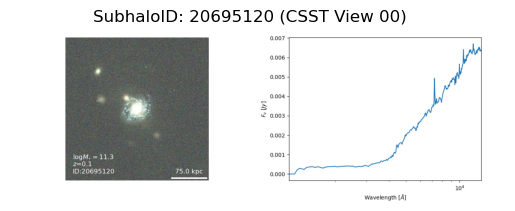

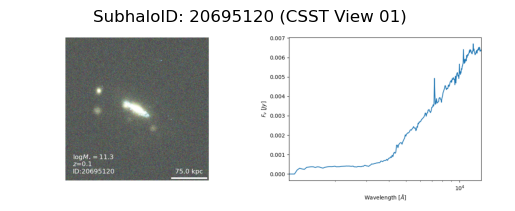

Finish postprocessing for CSST
Begin postprocessing for HSC


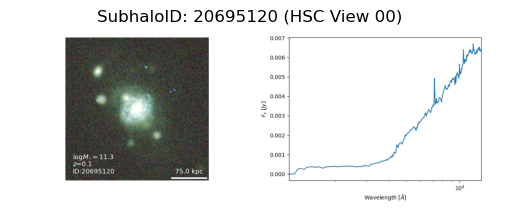

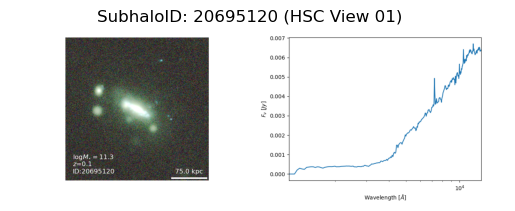

Finish postprocessing for HSC


In [24]:
postprocess = PostProcess(subhaloID=subhaloID, config=conf)
postprocess.runPostprocess(showImages=True)

## 9. Fits files

In [25]:
from astropy.io import fits

In [26]:
images = fits.open(f'mock_CSST/Subhalo_{subhaloID}/galaxy_image.fits')

In [27]:
images[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1748                                                  
NAXIS2  =                 1748                                                  
NAXIS3  =                    2                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
SNAPNUM =                   27 / Snapshot ID                                    
ID      =             20695120 / Subhalo ID                                     
MASS    =   1.0530956983566284 / Subhalo stellar mass, in log10 scale (Msun)    
SURVEY  = 'CSST    '           / Survey                                         
NFILTERS=                   

In [28]:
images[1].data.shape

(2, 1748, 1748)

In [29]:
for i in range(7):
    header = images[i+1].header
    if i == 0:
        print(f'{header["survey"]} filters: ')
    print(header['filter'], end='\t')



CSST filters: 
NUV	u	g	r	i	z	y	